In [42]:
import sympy as sm
import sympy.physics.mechanics as me
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from semiflex import SemiFlexBody
from utils import smaa
import pandas as pd
me.init_vprinting(use_latex="mathjax")

In [43]:
def fast_out_to_df(filename):
    with open(filename) as fid:
        headers = [fid.readline() for _ in range(6)]  # Read header
        channels = fid.readline().strip().split()  # Channel names
        units = fid.readline().strip().split()  # Channel units
        data = np.loadtxt(filename, skiprows=8)  # time series
        return pd.DataFrame(data=data, columns=channels)

In [44]:
t = me.dynamicsymbols._t
# masses
m_nac, m_rot = sm.symbols("m_nac, m_rot")

# distances
xn_cm, zn_cm, h_t, h_t_cm, d_nac_rot = sm.symbols("xn_cm, zn_cm,h_t, h_t_cm,d_nr")

Ixx_n, Iyy_n, Izz_n = sm.symbols("Ixx_n,Iyy_n,Izz_n")
Ixx_r, Iyy_r, Izz_r = sm.symbols("Ixx_r,Iyy_r,Izz_r")

# fixed angles
alpha = sm.symbols("alpha")
z, g, c_quad = sm.symbols("z, g, c_quad")

# Inertias
Ixx_n, Iyy_n, Izz_n = sm.symbols(
    "Ixx_n,Iyy_n,Izz_n"
)
# Torques and Forces
force_wind, torque_wind, torque_gen = sm.symbols("F_wind,T_w,T_g")

q3, u3 = me.dynamicsymbols("q3,u3")


In [45]:
E = me.ReferenceFrame("E")  # Earth
## Points
og = me.Point("O")
og.set_vel(E, 0)

tower = SemiFlexBody(E,og,'tower',zcm=h_t_cm,dof_x=2)
q1,q2 = tower.q
u1,u2 = tower.u

N = me.ReferenceFrame("N")  # Nacelle, rotated by tower deformations
N.orient_body_fixed(E, (0, tower.theta_x, 0), "XYZ")

R = me.ReferenceFrame("R")
R.orient_body_fixed(N, (alpha, q3, 0), "YXZ")
R.set_ang_vel(R, u3 * R.x)

nacelle_cm = og.locatenew(
    "nac_cm", h_t * E.z + zn_cm*N.z + xn_cm*N.x + (q1 + q2) * E.x 
)
rotor_cm = nacelle_cm.locatenew("rot_cm", -d_nac_rot * R.x)

I_nacelle = me.inertia(N, Ixx_n, Iyy_n, Izz_n)
I_rotor = me.inertia(R, Ixx_r, Iyy_r, Izz_r)

nacelle = me.RigidBody("nacelle", nacelle_cm, N, m_nac, (I_nacelle, nacelle_cm))
rotor = me.RigidBody("rotor", rotor_cm, R, m_rot, (I_rotor, rotor_cm))
# 2) your existing loads (gravity):

v_rot_x = rotor_cm.vel(E).dot(E.x) # rotor x velocity
quad_damp_force = sm.simplify(-c_quad * sm.Abs(v_rot_x) * v_rot_x)

loads = [
    # (tower_cm,   -m_t * g * E.z),
    (rotor_cm, quad_damp_force * E.x), # quad force
    (rotor_cm, -m_rot * g * E.z),
    (rotor_cm, force_wind * R.x),
    (nacelle_cm, -m_nac * g * E.z),
    (R, torque_wind * R.x),
    (R, -torque_gen * R.x),
    (N, torque_gen * R.x), 
]

## add tower contribution to loads and bodies
bodies =  [nacelle, rotor] + tower.get_bodies()
loads = loads + tower.loads

coordinates = [q1, q2, q3]
speeds = [u1, u2, u3]
kin_eqs = [q1.diff(t) - u1, q2.diff(t) - u2, q3.diff(t) - u3]

nacelle_cm.v1pt_theory(og,E,E)
# # 5. Set up Kane’s method
KM = me.KanesMethod(E, q_ind=coordinates, u_ind=speeds, kd_eqs=kin_eqs)

# # # 4) form the equations
fr, frstar = KM.kanes_equations(bodies=bodies, loads=loads)

/home/lorenzo/miniconda3/envs/openfast/lib/python3.12/site-packages/sympy/physics/vector/point.py:577: UserWarning: 
Velocity of nac_cm automatically calculated based on point O but it is
also possible from points(s): [rot_cm]. Velocities from these points
are not necessarily the same. This may cause errors in your
calculations.
  warn(filldedent(f"""


In [46]:
tower.loads

[(op_xTO_1, - k_xTO_1*q1(t)*E.x),
 (op_xTO_2, - k_xTO_2*q2(t)*E.x),
 (op_xTO_1, - c_xTO_1*u1(t)*E.x),
 (op_xTO_2, - c_xTO_2*u2(t)*E.x)]

In [47]:
mass_full = KM.mass_matrix_full
forcing_full = KM.forcing_full
# mass_full = sm.trigsimp(KM.mass_matrix_full)
# forcing_full = sm.trigsimp(KM.forcing_full)
state_syms = [q1,q2,q3,u1,u2,u3]
ext_forces = [force_wind,torque_wind,torque_gen]

In [48]:
rotor.masscenter.pos_from(og)

-dₙᵣ r_x + (q₁ + q₂) e_x + hₜ e_z + xn_cm n_x + zn_cm n_z

In [49]:
all_free_symbols = (mass_full.free_symbols | forcing_full.free_symbols) - set(ext_forces +[t])

sorted_syms = sorted([str(x) for x in all_free_symbols])
print({k: 0.0 for k in sorted_syms}) # to create a placeholder for subs_num

{'Ixx_r': 0.0, 'Iyy_n': 0.0, 'Iyy_r': 0.0, 'Izz_r': 0.0, 'alpha': 0.0, 'c_quad': 0.0, 'c_xTO_1': 0.0, 'c_xTO_2': 0.0, 'd_nr': 0.0, 'g': 0.0, 'k_xTO_1': 0.0, 'k_xTO_2': 0.0, 'm_nac': 0.0, 'm_rot': 0.0, 'm_xTO_1': 0.0, 'm_xTO_2': 0.0, 'r_xTO_1': 0.0, 'r_xTO_2': 0.0, 'xn_cm': 0.0, 'zn_cm': 0.0}


In [50]:
import pandas as pd
from scipy.interpolate import PchipInterpolator

dforce = pd.read_csv(f"./fast_force_5.tsv", sep=r"\s+")
dfwind = pd.read_csv(f"./fast_wind_5.tsv", sep=r"\s+")
df1 = pd.read_csv('FEM_SSM_out_fast_force_5.csv')
dfw5 = fast_out_to_df("/home/lorenzo/Desktop/feuphd/openfast_5mw_francisco/5MW_W0500_T1000_S01.out")

In [51]:
# (np.float64(1817681.463680637), np.float64(1473289466.502628))
# k1, k2 = 1.91268637e+06, 1.02301447e+10
k1, k2 = 1817681.4, 1473289466.5
mt1,mt2 =  55_653.9, 3_588_258.6
r_1t = 0.0185
r_2t = 0.168
# c_damp = 330_000

c_damp1 = 0.01*2*np.sqrt(mt1*k1)
c_damp2 = 0.02*2*np.sqrt(mt2*k2)

# Ixx_r = 2.85235e+07
# Iyy_n = 3.09992e+06
# Iyy_r = 3.18699e+08
# Izz_r = 3.18699e+08

subs_dims = {
    "Ixx_r": 2.85235e+07,
    "Iyy_n": 3.07e6,
    "Iyy_r": 3.18699e+08,
    "Izz_r": 3.18699e+08,
    "alpha": np.deg2rad(5),
    "c_xTO_1": c_damp1,
    "c_xTO_2": c_damp2,
    "c_quad": 0.0,
    "d_nr": 5,
    "g": 9.81,
    "k_xTO_1": k1,
    "k_xTO_2": k2,
    "m_nac": 240_000,
    "m_rot": 110_000,
    "m_xTO_1": mt1,
    "m_xTO_2": mt2,
    "r_xTO_1": r_1t,
    "r_xTO_2": r_2t,
    "xn_cm": 1.9,
    "zn_cm": 1.75,
}

In [52]:
import pickle

results_to_save = {
    'mass_full': mass_full,
    'forcing_full': forcing_full,
    'mass_sma': smaa(mass_full,tower.theta_x),
    'forcing_sma':smaa(forcing_full,tower.theta_x),
    'coordinates' : coordinates,
    'speeds' : speeds,
    'ext_forces': ext_forces
}

with open('3dof_km_res.pkl', 'wb') as f:
    pickle.dump(results_to_save, f)

# print("Results saved to 5dof_km_res.pkl")

# --- LOAD FROM FILE ---
# You can run this part in a completely new script.
# Use 'rb' for 'read bytes'
with open('3dof_km_res.pkl', 'rb') as f:
    loaded_results = pickle.load(f)

In [12]:
from sympy.physics.mechanics import find_dynamicsymbols

In [13]:
find_dynamicsymbols(forcing_full[3])

{q₁, q₂, q₃, u₁, u₂, u₃}

In [14]:
force_interp = PchipInterpolator(dforce['Time'],dforce['YawBrFxp'])
torque_interp = PchipInterpolator(dforce['Time'],dforce['RotTorq'])
wind_interp = PchipInterpolator(dfwind['Time'],dfwind['Wind1VelX'])

In [15]:
from force_controlers import rotor_torque,generator_torque_control

In [16]:
from bem_ds4 import IdealHAWT

In [17]:
turbine = IdealHAWT(64)

In [18]:
omega = np.linspace(0.1,5,300)

In [19]:
# 1. Substitute values
# M_num = KM.mass_matrix_full.subs(subs_dims)
# F_num = KM.forcing_full.subs(subs_dims)
turbine = IdealHAWT(64)

# 2. Lambdify for fast evaluation
state_syms = [q1, q2, q3, u1, u2,u3]
ext_forces = [force_wind,torque_wind,torque_gen]
M_func = sm.lambdify(state_syms, mass_full.subs(subs_dims), 'numpy')
F_func = sm.lambdify(state_syms+ext_forces, forcing_full.subs(subs_dims), 'numpy')

# F_func_sma = sm.lambdify(state_syms+ext_forces, smaa(KM.forcing,tower.theta_x).subs(subs_dims), 'numpy')
omega_max = 1.5
k_p = 0.5

In [20]:
ext_forces = []
def rhs(t, y):
    M = M_func(*y)
    Qw = torque_interp(t)
    Qg = max(generator_torque_control(Qw,y[5],omega_max,k_p),0)
    Fw = force_interp(t)
    ext_forces.append([t,1e-3*Fw,1e-3*Qw,1e-3*Qg])
    F = F_func(*y,Fw,Qw,Qg).flatten()
    return np.linalg.solve(M, F)

In [21]:
ext_forces_w = []
def rhsw(t, y):
    M = M_func(*y)
    ws = wind_interp(t)
    omega = y[5]
    Qw = turbine.total_torque(ws,omega)
    Qg = max(generator_torque_control(Qw,y[5],omega_max,k_p),0)
    Fw = turbine.total_thrust(ws,omega)
    ext_forces_w.append([t,1e-3*Fw,1e-3*Qw,1e-3*Qg])
    F = F_func(*y,Fw,Qw,Qg).flatten()
    return np.linalg.solve(M, F)

In [22]:
# 4. Integrate
y0 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  # initial conditions: [q1, q2, u1, u2]
t_span = (0, 50)
# sol = solve_ivp(rhs, t_span, y0)
sol = solve_ivp(rhs, t_span, y0)
solw = solve_ivp(rhsw, t_span, y0)

In [23]:
ext_forces = np.array(ext_forces)
ext_forces_w = np.array(ext_forces_w)

In [24]:
df3 = pd.read_csv('3dof_out_wind.tsv',sep=r"\s+")

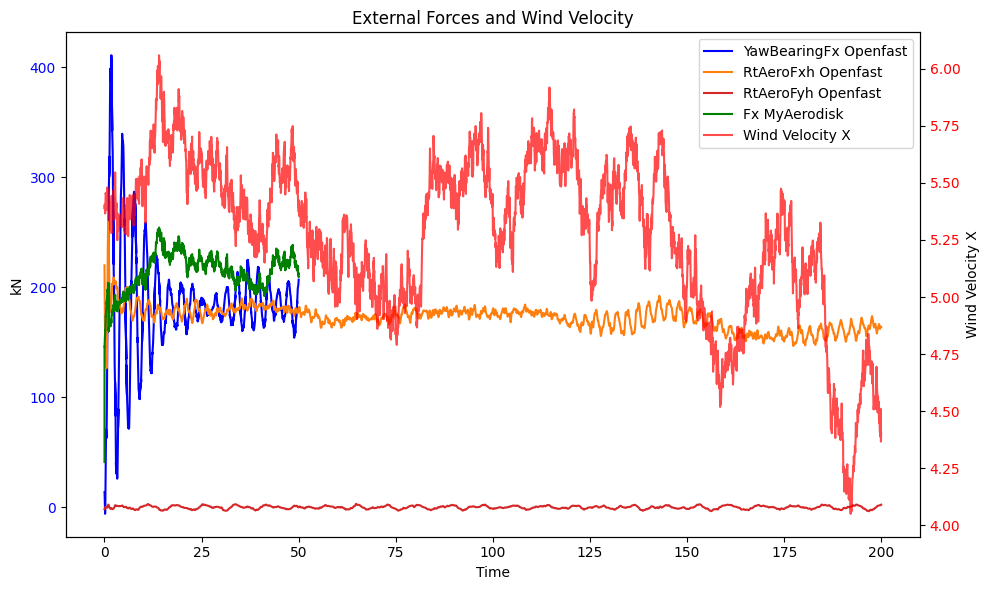

In [25]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot external forces on primary y-axis
ax1.plot(ext_forces[:,0], ext_forces[:,1], label='YawBearingFx Openfast', color='blue')
ax1.plot(dfw5['Time'][:4000], 1e-3*dfw5['RtAeroFxh'][:4000], label='RtAeroFxh Openfast', color='C1')
ax1.plot(dfw5['Time'][:4000], 1e-3*dfw5['RtAeroFyh'][:4000], label='RtAeroFyh Openfast', color='C3')
ax1.plot(ext_forces_w[:,0], ext_forces_w[:,1], label='Fx MyAerodisk', color='green')
ax1.set_xlabel('Time')
ax1.set_ylabel('kN')
ax1.tick_params(axis='y', labelcolor='blue')

# Create secondary y-axis for wind data
ax2 = ax1.twinx()
ax2.plot(dfwind['Time'][:4000], dfwind['Wind1VelX'][:4000], 
         label='Wind Velocity X', color='red', alpha=0.7)
ax2.set_ylabel('Wind Velocity X')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.title('External Forces and Wind Velocity')
plt.tight_layout()
plt.show()

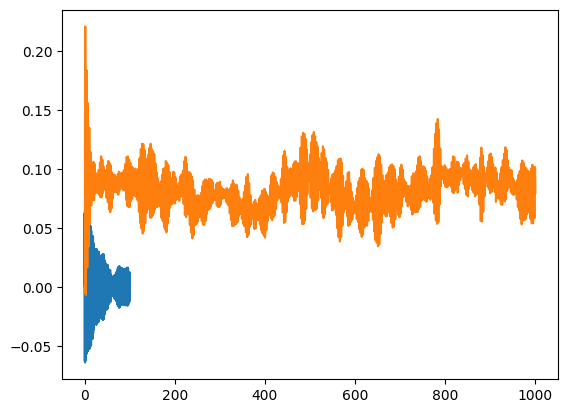

In [36]:
plt.plot(df3['t'],df3['u1']+df3['u2'])
plt.plot(dfw5['Time'],dfw5['YawBrTDxp'])

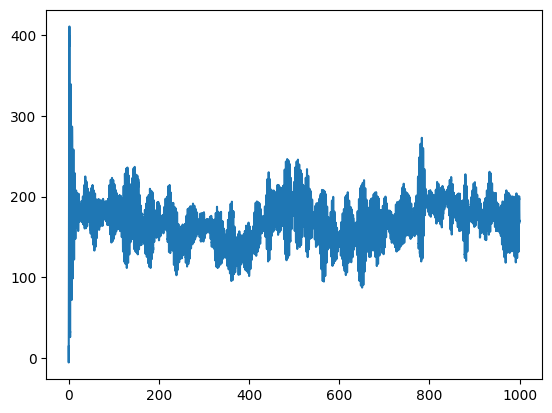

In [ ]:
# plt.plot(dforce['Time'],1e-3*dforce['YawBrFxp'])

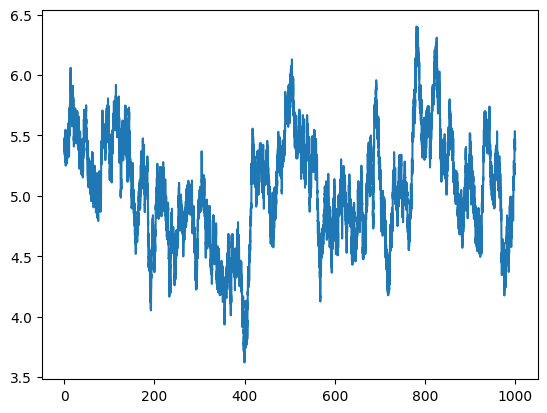

In [41]:
plt.plot(dfwind['Time'],dfwind['Wind1VelX'])

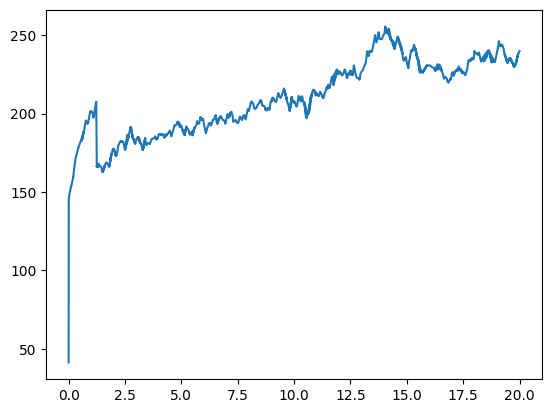

In [52]:
plt.plot(ext_forces_w[:,0],ext_forces_w[:,1])

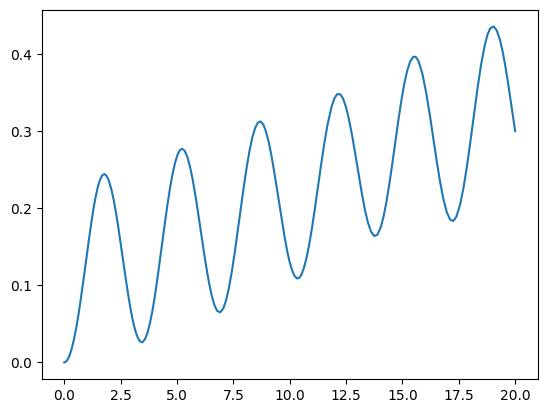

In [53]:
plt.plot(sol.t,sol.y[0,:]+sol.y[1,:])

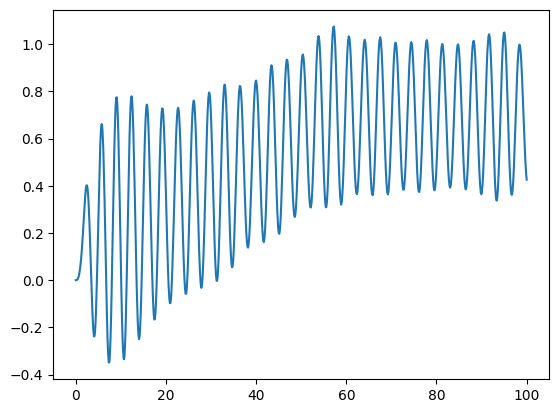

In [216]:
plt.plot(sol.t,sol.y[0,:]+sol.y[1,:])

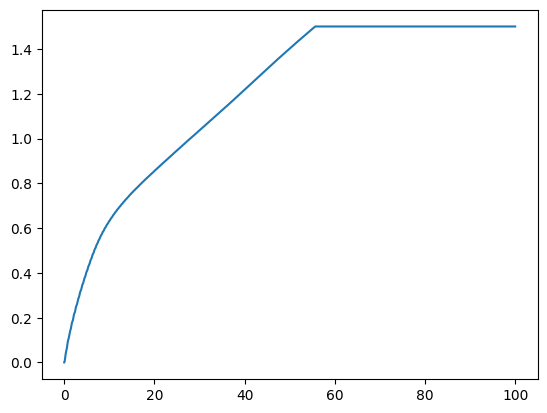

In [43]:
plt.plot(sol.t[:],sol.y[5,:])

In [15]:
dt=0.05

disp_pchip = PchipInterpolator(sol.t,sol.y[0,:]+sol.y[1,:])
df1['disp_pred'] = disp_pchip(df1['time'])
acc = np.diff(df1['disp_pred'],2)/dt**2
df1['acc_pred'] = np.concat([[acc[0]],acc,[acc[-1]]])


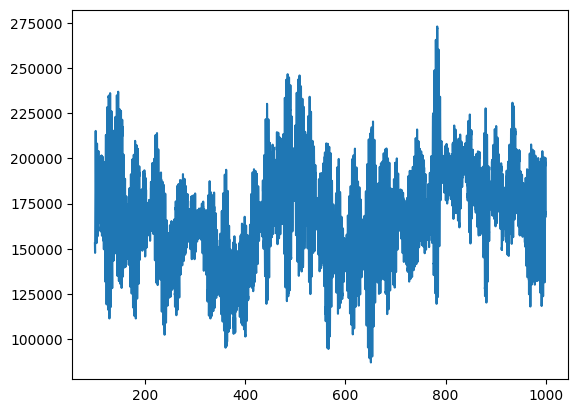

In [16]:
plt.plot(dforce['Time'][2000:],dforce['YawBrFxp'][2000:])

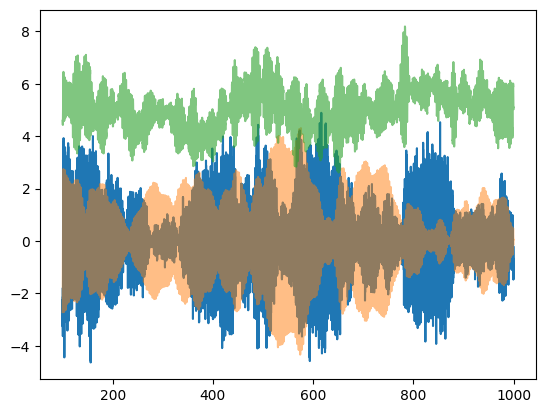

In [17]:
plt.plot(df1['time'],df1['acc_pred'])
plt.plot(df1['time'],df1['y_876_dm'],alpha=0.5)
plt.plot(dforce['Time'][2000:],3e-5*dforce['YawBrFxp'][2000:],alpha=0.6)